# Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import os
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG19
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.models import Sequential
from tensorflow.keras.saving import load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Предобработка данных

In [2]:
data_path = '/content/drive/MyDrive/Colab Notebooks/ВКР/brain_tumor_mri/'

In [3]:
classes = os.listdir(data_path)

In [4]:
def plot_class(path):
    plt.figure(figsize=(12,12))
    title = path.split('/')[-1]
    for i in range(1,5):
        plt.subplot(1,4,i)
        plt.tight_layout()
        rand_img = plt.imread(path +'/'+ random.choice(sorted(os.listdir(path))))
        plt.imshow(rand_img)
        plt.title(title, fontsize=15, color='blue')
        plt.xticks([])
        plt.yticks([])

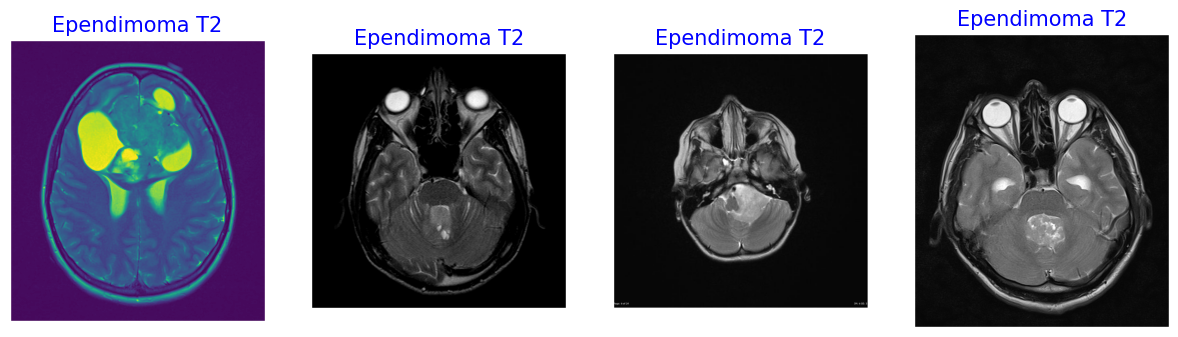

In [5]:
plot_class(data_path+classes[0])

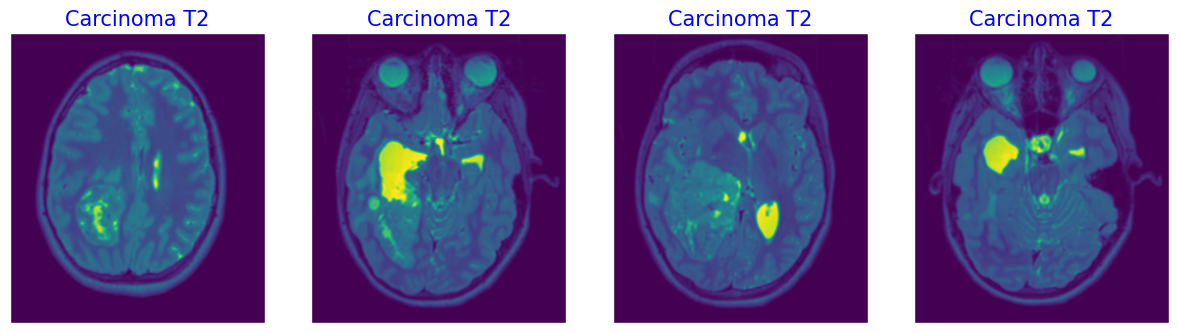

In [6]:
plot_class(data_path+classes[1])

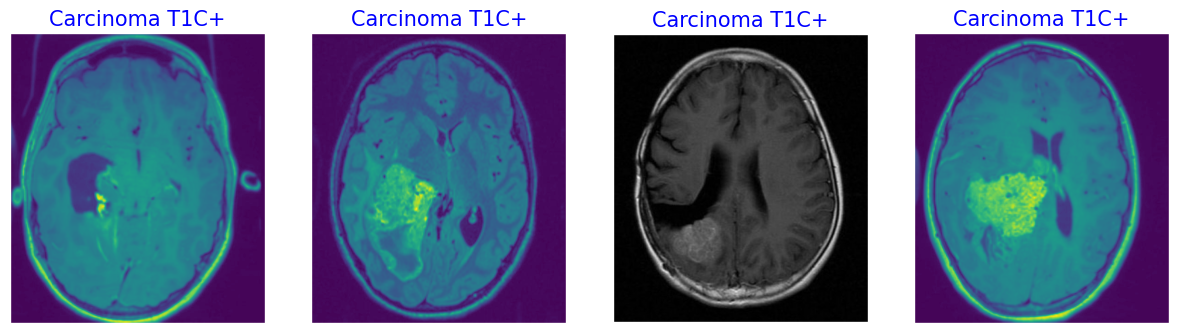

In [7]:
plot_class(data_path+classes[2])

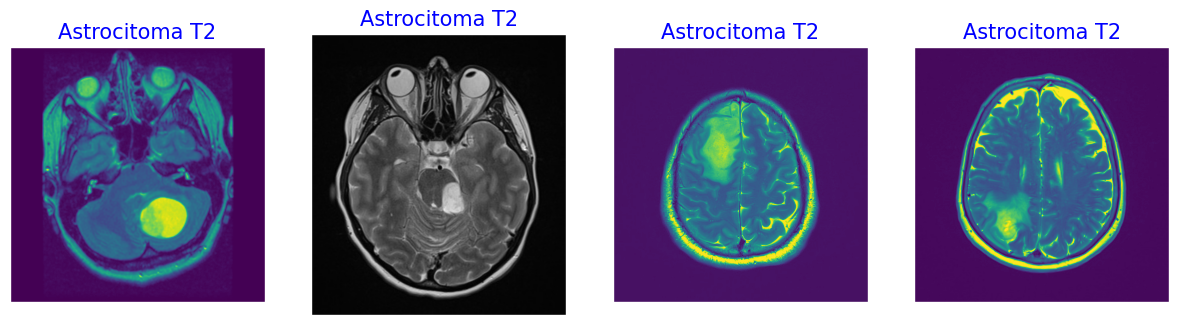

In [8]:
plot_class(data_path+classes[3])

In [9]:
def main(train_data_path):
    
    for dirs in [train_data_path]:

        filepaths = []
        labels = []
        classes_list = sorted(os.listdir(dirs))

        filepaths,labels = get_fileList(classes_list, dirs, filepaths, labels)
        
        train_df = obtain_train_df(filepaths, labels)
        
            
    return train_df



def get_fileList(classes_list, dirs, filepaths, labels):

    for s_class in classes_list:
        
        label = s_class
        classpath = os.path.join(dirs, s_class)
        flist = sorted(os.listdir(classpath))
        
        store_image_names_and_its_labels(flist, classpath, filepaths, labels, label)
        
    return filepaths, labels


def store_image_names_and_its_labels(flist, classpath, filepaths, labels, label):
    
    for file in flist:
        file_path = os.path.join(classpath, file)
        filepaths.append(file_path)
        labels.append(label)



def obtain_train_df(filepaths, labels):

    train_df =pd.DataFrame({
        'image_path' : filepaths,
        'label' : labels
    })
    return train_df

In [10]:
data_df = main(data_path)

In [11]:
data_df.head()

,image_path,label
0,/content/drive/MyDrive/Colab Notebooks/ВКР/bra...,Astrocitoma T1
1,/content/drive/MyDrive/Colab Notebooks/ВКР/bra...,Astrocitoma T1
2,/content/drive/MyDrive/Colab Notebooks/ВКР/bra...,Astrocitoma T1
3,/content/drive/MyDrive/Colab Notebooks/ВКР/bra...,Astrocitoma T1
4,/content/drive/MyDrive/Colab Notebooks/ВКР/bra...,Astrocitoma T1


In [12]:
num_classes = len(data_df['label'].unique())
print(f"We have {num_classes} classes")
print(f"We have {data_df.shape[0]} images")

We have 44 classes
We have 4489 images


In [13]:
data_df['label'].value_counts()

Meningioma T1C+           369
Meningioma T1             272
_NORMAL T2                271
_NORMAL T1                251
Astrocitoma T1C+          233
Meningioma T2             233
Neurocitoma T1C+          223
Schwannoma T1C+           194
Astrocitoma T1            176
Astrocitoma T2            171
Schwannoma T1             148
Neurocitoma T1            130
Schwannoma T2             123
Carcinoma T1C+            112
Papiloma T1C+             108
Neurocitoma T2            104
Glioblastoma T1C+          94
Oligodendroglioma T1       94
Tuberculoma T1C+           84
Oligodendroglioma T1C+     74
Carcinoma T2               73
Meduloblastoma T1C+        67
Papiloma T1                66
Oligodendroglioma T2       66
Carcinoma T1               66
Papiloma T2                63
Ependimoma T2              57
Glioblastoma T2            55
Glioblastoma T1            55
Ependimoma T1C+            48
Ependimoma T1              45
Meduloblastoma T2          41
Germinoma T1C+             40
Tuberculom

In [14]:
def count_plot(x, title, xlabel, ylabel, width, length, order = None, rotation=False, palette='winter'):
    plt.figure(figsize=(width,length))
    sns.countplot(x = x, palette=palette, order = order)
    plt.title(title, fontsize=25)
    if rotation:
        plt.xticks(rotation = 'vertical')
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.show()

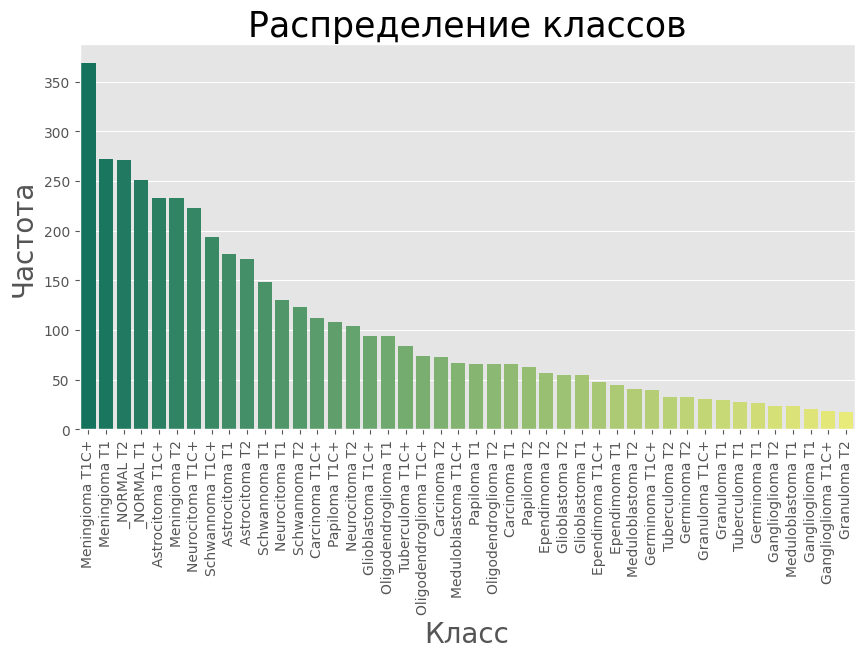

In [15]:
x = data_df['label']
order = x.value_counts().index
count_plot(x, "Распределение классов", "Класс", 'Частота', 10,5, rotation = True, order=order, palette='summer')

In [16]:
def define_paths(dir):
    filepaths = []
    labels = []

    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            fold = str(fold).replace('C+', '')
            labels.append(fold[:-3])

    return filepaths, labels

def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

In [17]:
def tr_ts_data(tr_dir, ts_dir):
    
    files, classes = define_paths(tr_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, valid_df = train_test_split(df, train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

    files, classes = define_paths(tr_dir)
    test_df = define_df(files, classes)
    return train_df, valid_df, test_df

def full_data(data_dir):

    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

    return train_df, valid_df, test_df

def tr_val_ts_data(tr_dir, val_dir, ts_dir):

    files, classes = define_paths(tr_dir)
    train_df = define_df(files, classes)

    files, classes = define_paths(val_dir)
    valid_df = define_df(files, classes)

    files, classes = define_paths(ts_dir)
    test_df = define_df(files, classes)

    return train_df, valid_df, test_df

In [18]:
def split_data(tr_dir, val_dir=None, ts_dir=None):

    if val_dir == '' and ts_dir == '':
        train_df, valid_df, test_df = full_data(tr_dir)
        return train_df, valid_df, test_df

    elif val_dir == '' and ts_dir != '':
        train_df, valid_df, test_df = tr_ts_data(tr_dir, ts_dir)
        return train_df, valid_df, test_df

    elif val_dir != '' and ts_dir != '':
        train_df, valid_df, test_df = tr_val_ts_data(tr_dir, val_dir, ts_dir)
        return train_df, valid_df, test_df

In [19]:
def create_model_data (train_df, valid_df, test_df, batch_size):

    img_size = (224, 224)
    channels = 3 # either BGR or Grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size

    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(preprocessing_function= scalar, 
                                horizontal_flip= True)
    
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)

    train_gen = tr_gen.flow_from_dataframe( train_df, 
                                           x_col= 'filepaths', 
                                           y_col= 'labels', 
                                           target_size= img_size, 
                                           class_mode= 'categorical',
                                           color_mode= color, 
                                           shuffle= True, 
                                           batch_size= batch_size)

    valid_gen = ts_gen.flow_from_dataframe( valid_df, 
                                           x_col= 'filepaths', 
                                           y_col= 'labels', 
                                           target_size= img_size, 
                                           class_mode= 'categorical',
                                           color_mode= color, 
                                           shuffle= True, 
                                           batch_size= batch_size)

    test_gen = ts_gen.flow_from_dataframe( test_df, 
                                          x_col= 'filepaths', 
                                          y_col= 'labels', 
                                          target_size= img_size, 
                                          class_mode= 'categorical',
                                          color_mode= color, 
                                          shuffle= False, 
                                          batch_size= test_batch_size)

    return train_gen, valid_gen, test_gen

In [20]:
def show_images(gen):

    g_dict = gen.class_indices
    classes = list(g_dict.keys())
    images, labels = next(gen)

    length = len(labels) 
    sample = min(length, 25)  

    plt.figure(figsize= (10, 10))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255      
        plt.imshow(image)
        index = np.argmax(labels[i])  
        class_name = classes[index]  
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()
    


In [26]:
train_

Meningioma           699
Astrocitoma          464
_NORMAL              417
Schwannoma           372
Neurocitoma          366
Carcinoma            201
Papiloma             190
Oligodendroglioma    187
Glioblastoma         163
Ependimoma           120
Tuberculoma          116
Meduloblastoma       105
Germinoma             80
Granuloma             62
Ganglioglioma         49
Name: labels, dtype: int64

In [21]:
def plot_label_count(df, plot_title):

    vcounts = df['labels'].value_counts()
    labels = vcounts.keys().tolist()
    values = vcounts.tolist()
    lcount = len(labels)

    if lcount > 55:
        print('The number of labels is > 55, no plot will be produced')

    else:
        plot_labels(lcount, labels, values, plot_title)

def plot_labels(lcount, labels, values, plot_title):
    width = lcount * 4
    width = np.min([width, 20])

    plt.figure(figsize= (width, 5))

    form = {'family': 'serif', 'color': 'blue', 'size': 25}
    sns.barplot(x=labels, y=values)
    plt.title(f'Images per Label in {plot_title} data', fontsize= 24, color= 'blue')
    plt.xticks(rotation= 90, fontsize= 18)
    plt.yticks(fontsize= 18)
    plt.xlabel('CLASS', fontdict= form)
    yaxis_label = 'IMAGE COUNT'
    plt.ylabel(yaxis_label, fontdict= form)

    rotation = 'vertical' if lcount >= 8 else 'horizontal'
    for i in range(lcount):
        plt.text(i, values[i] / 2, str(values[i]), fontsize= 12,
                rotation= rotation, color= 'yellow', ha= 'center')

    plt.show()

In [22]:
train_dir = data_path
valid_dir = input('Enter validation data directory (if no valid dir press Enter): ')
test_dir = input('Enter test data directory (if no test dir press Enter): ')

train_df, valid_df, test_df = split_data(train_dir, valid_dir, test_dir)

batch_size = 32
train_gen, valid_gen, test_gen = create_model_data(train_df, valid_df, test_df, batch_size)

Enter validation data directory (if no valid dir press Enter): 
Enter test data directory (if no test dir press Enter): 
Found 3590 validated image filenames belonging to 15 classes.


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(


Found 449 validated image filenames belonging to 15 classes.
Found 449 validated image filenames belonging to 15 classes.


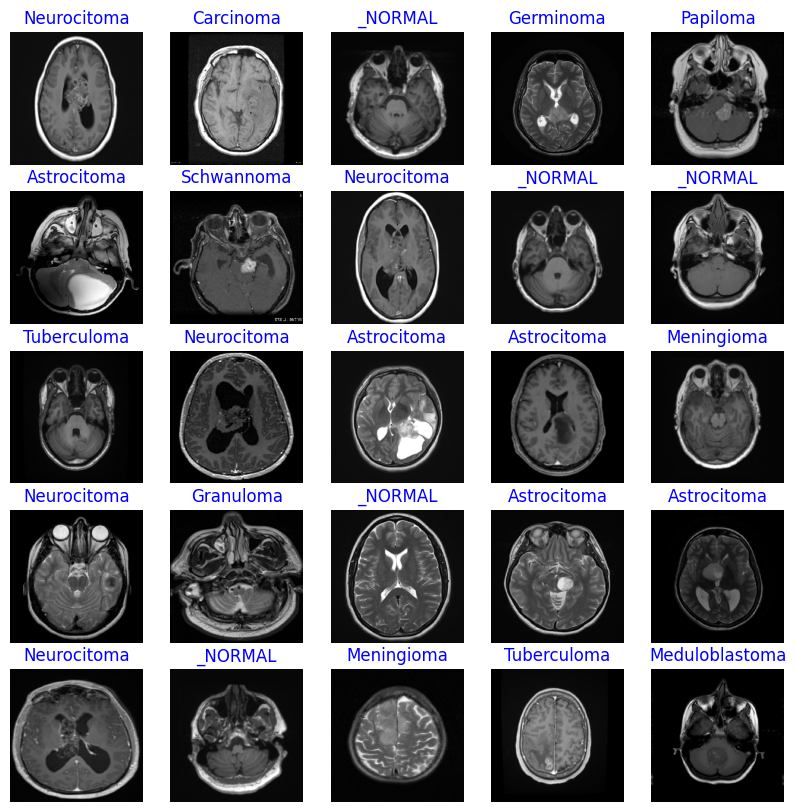

In [23]:
show_images(train_gen)

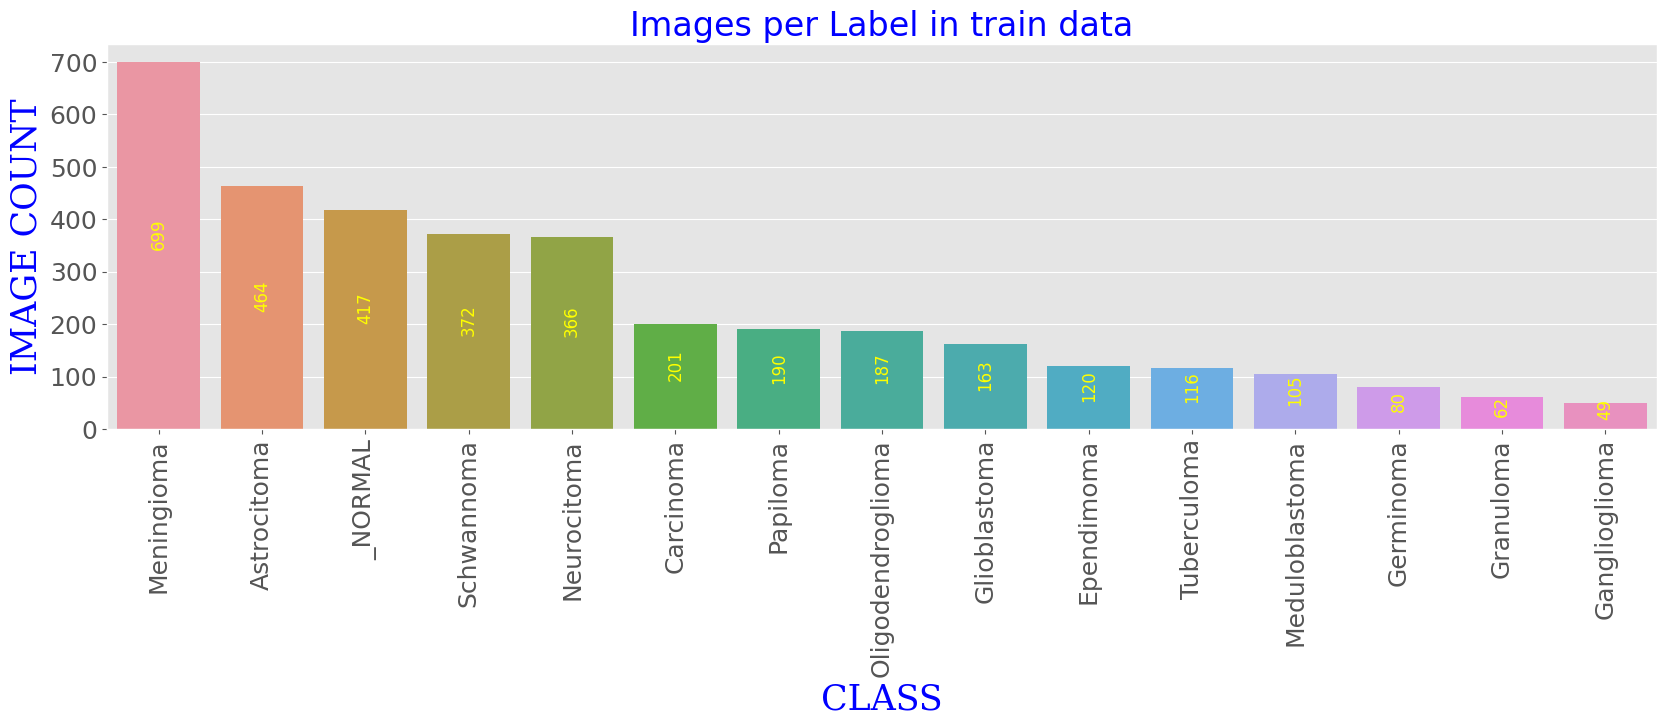

In [24]:
plot_label_count(train_df, 'train')

# Обучение моделей

In [ ]:
def plot_training(hist):

    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    plt.figure(figsize= (15, 6))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 100, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 100, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

## Модель EfficientNet

In [ ]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))


base_model = tf.keras.applications.efficientnet.EfficientNetB5(include_top= False, 
                                                               weights= "imagenet", 
                                                               input_shape= img_shape, 
                                                               pooling= 'max')

In [ ]:
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, 
          kernel_regularizer= regularizers.l2(l= 0.016), 
          activity_regularizer= regularizers.l1(0.006),
          bias_regularizer= regularizers.l1(0.006), 
          activation= 'relu'),
    
    Dropout(rate= 0.45, 
            seed= 123),
    
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional)  (None, 2048)             28513527  
                                                                 
 batch_normalization_2 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 256)               524544    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 15)                3855      
                                                                 
Total params: 29,050,118
Trainable params: 28,873,279
Non-trainable params: 176,839
____________________________________

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=10,
                           verbose=1)

checkpoint = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/ВКР/EfficientNetB5_model_weights.h5', 
                             monitor='val_loss', 
                             save_best_only=True, 
                             save_weights_only=True, 
                             mode='min', 
                             verbose=1)


history = model.fit(x= train_gen, 
                    epochs= 20, 
                    callbacks=[early_stop, checkpoint],
                    validation_data= valid_gen)

Epoch 1/20
113/113 [==============================] - ETA: 0s - loss: 9.0561 - accuracy: 0.5276
Epoch 1: val_loss improved from inf to 8.18036, saving model to /content/drive/MyDrive/Colab Notebooks/ВКР/EfficientNetB5_model_weights.h5
113/113 [==============================] - 219s 1s/step - loss: 9.0561 - accuracy: 0.5276 - val_loss: 8.1804 - val_accuracy: 0.6102
Epoch 2/20
113/113 [==============================] - ETA: 0s - loss: 6.6345 - accuracy: 0.8067
Epoch 2: val_loss improved from 8.18036 to 6.39043, saving model to /content/drive/MyDrive/Colab Notebooks/ВКР/EfficientNetB5_model_weights.h5
113/113 [==============================] - 108s 956ms/step - loss: 6.6345 - accuracy: 0.8067 - val_loss: 6.3904 - val_accuracy: 0.6971
Epoch 3/20
113/113 [==============================] - ETA: 0s - loss: 5.1871 - accuracy: 0.9206
Epoch 3: val_loss improved from 6.39043 to 5.12705, saving model to /content/drive/MyDrive/Colab Notebooks/ВКР/EfficientNetB5_model_weights.h5
113/113 [===========

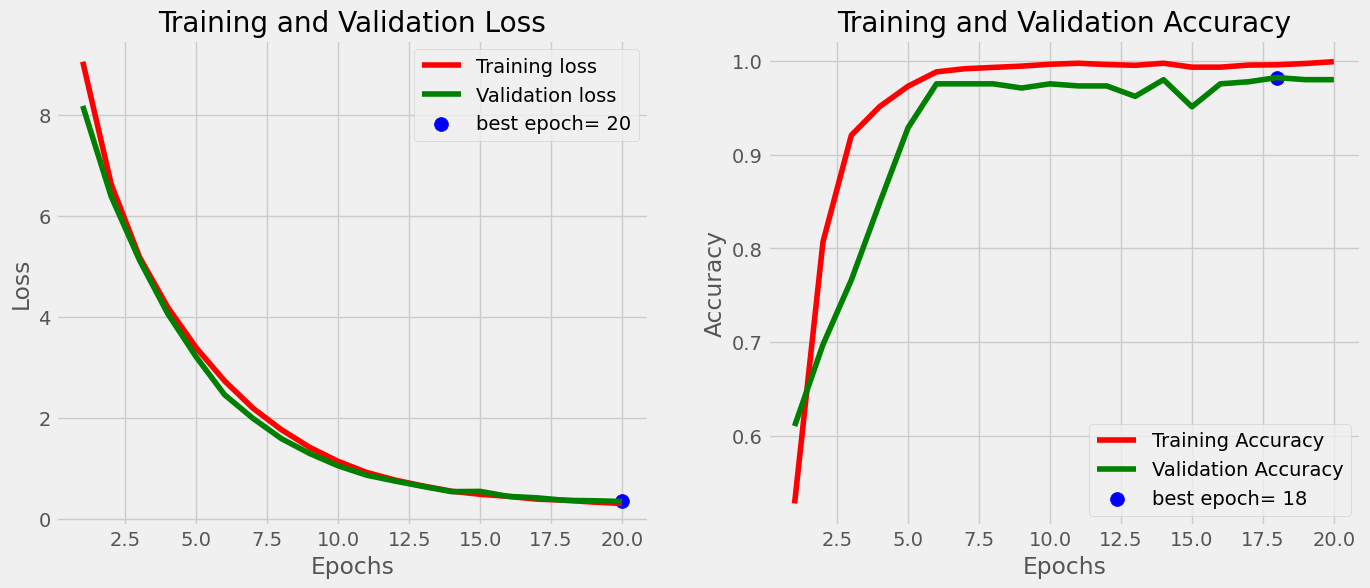

In [ ]:
plot_training(history)

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

113/449 [======>.......................] - ETA: 1:22 - loss: 0.2592 - accuracy: 0.9997

 14/449 [..............................] - ETA: 1:33 - loss: 0.3480 - accuracy: 0.9799

449/449 [==============================] - 13s 28ms/step - loss: 0.3347 - accuracy: 0.9844
Train Loss:  0.259163498878479
Train Accuracy:  0.9997214674949646
--------------------
Validation Loss:  0.3478085398674011
Validation Accuracy:  0.9799554347991943
--------------------
Test Loss:  0.3346673250198364
Test Accuracy:  0.9844098091125488


In [ ]:
y_pred = model.predict(test_gen)

y_pred_labels = np.argmax(y_pred, axis=1)

y_true_labels = test_gen.classes

449/449 [==============================] - 15s 26ms/step


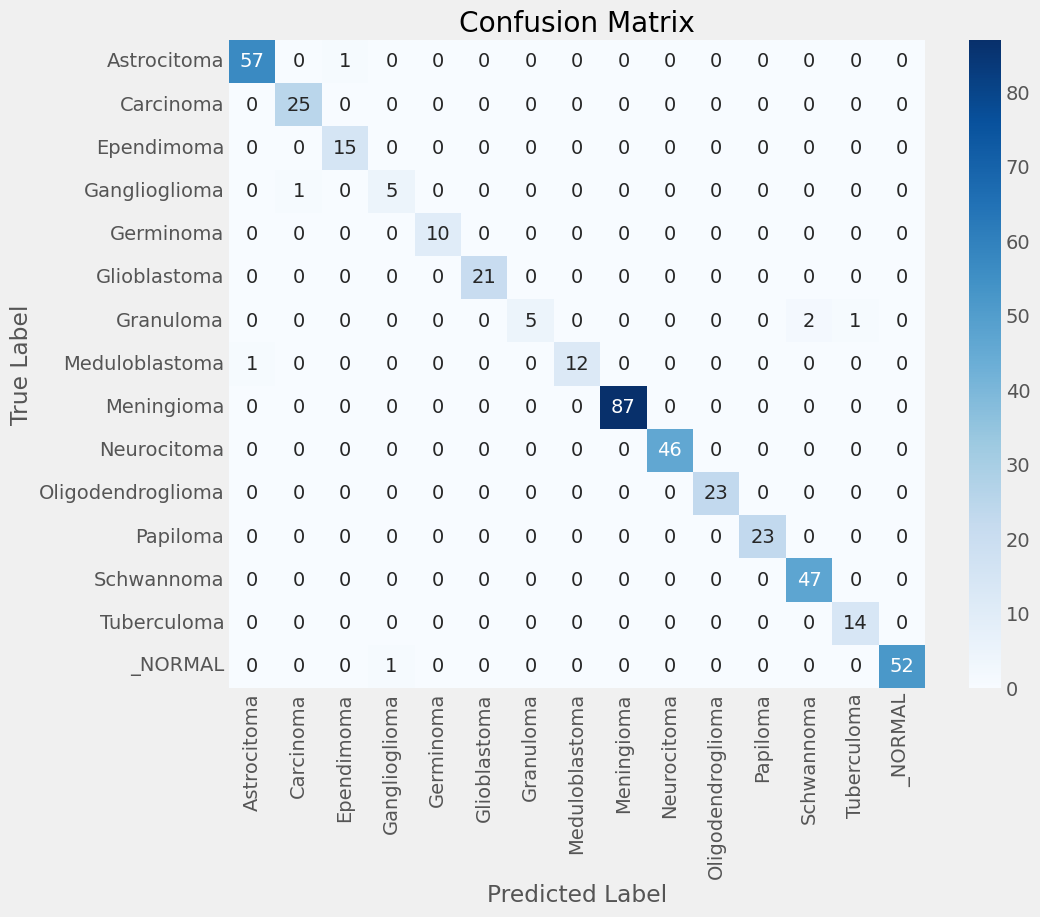

In [ ]:
class_names = list(test_gen.class_indices.keys())

confusion_mtx = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, cmap="Blues", annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
report = classification_report(y_true_labels, y_pred_labels, target_names=class_names)

print("Classification Report: ")
print(report)

Classification Report: 
                   precision    recall  f1-score   support

      Astrocitoma       0.98      0.98      0.98        58
        Carcinoma       0.96      1.00      0.98        25
       Ependimoma       0.94      1.00      0.97        15
    Ganglioglioma       0.83      0.83      0.83         6
        Germinoma       1.00      1.00      1.00        10
     Glioblastoma       1.00      1.00      1.00        21
        Granuloma       1.00      0.62      0.77         8
   Meduloblastoma       1.00      0.92      0.96        13
       Meningioma       1.00      1.00      1.00        87
      Neurocitoma       1.00      1.00      1.00        46
Oligodendroglioma       1.00      1.00      1.00        23
         Papiloma       1.00      1.00      1.00        23
       Schwannoma       0.96      1.00      0.98        47
      Tuberculoma       0.93      1.00      0.97        14
          _NORMAL       1.00      0.98      0.99        53

         accuracy             

## Модель ConvNeXt

In [ ]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))


base_model = tf.keras.applications.convnext.ConvNeXtTiny(include_top= False, 
                                                               weights= "imagenet", 
                                                               input_shape= img_shape, 
                                                               pooling= 'max')

In [ ]:
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, 
          kernel_regularizer= regularizers.l2(l= 0.016), 
          activity_regularizer= regularizers.l1(0.006),
          bias_regularizer= regularizers.l1(0.006), 
          activation= 'relu'),
    
    Dropout(rate= 0.45, 
            seed= 123),
    
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convnext_tiny (Functional)  (None, 768)               27820128  
                                                                 
 batch_normalization_3 (Batc  (None, 768)              3072      
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 256)               196864    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 15)                3855      
                                                                 
Total params: 28,023,919
Trainable params: 28,022,383
Non-trainable params: 1,536
______________________________________

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=10,
                           verbose=1)

checkpoint = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/ВКР/MRI_ConvNext_model_weights.h5', 
                             monitor='val_loss', 
                             save_best_only=True, 
                             save_weights_only=True, 
                             mode='min', 
                             verbose=1)


history = model.fit(x= train_gen, 
                    epochs= 20, 
                    callbacks=[early_stop, checkpoint],
                    validation_data= valid_gen)

Epoch 1/20
113/113 [==============================] - ETA: 0s - loss: 8.1917 - accuracy: 0.3772
Epoch 1: val_loss improved from inf to 7.62246, saving model to /content/drive/MyDrive/Colab Notebooks/ВКР/MRI_ConvNext_model_weights.h5
113/113 [==============================] - 143s 918ms/step - loss: 8.1917 - accuracy: 0.3772 - val_loss: 7.6225 - val_accuracy: 0.1425
Epoch 2/20
113/113 [==============================] - ETA: 0s - loss: 6.0734 - accuracy: 0.6674
Epoch 2: val_loss improved from 7.62246 to 6.27960, saving model to /content/drive/MyDrive/Colab Notebooks/ВКР/MRI_ConvNext_model_weights.h5
113/113 [==============================] - 90s 791ms/step - loss: 6.0734 - accuracy: 0.6674 - val_loss: 6.2796 - val_accuracy: 0.3252
Epoch 3/20
113/113 [==============================] - ETA: 0s - loss: 4.7498 - accuracy: 0.8003
Epoch 3: val_loss improved from 6.27960 to 5.07263, saving model to /content/drive/MyDrive/Colab Notebooks/ВКР/MRI_ConvNext_model_weights.h5
113/113 [===============

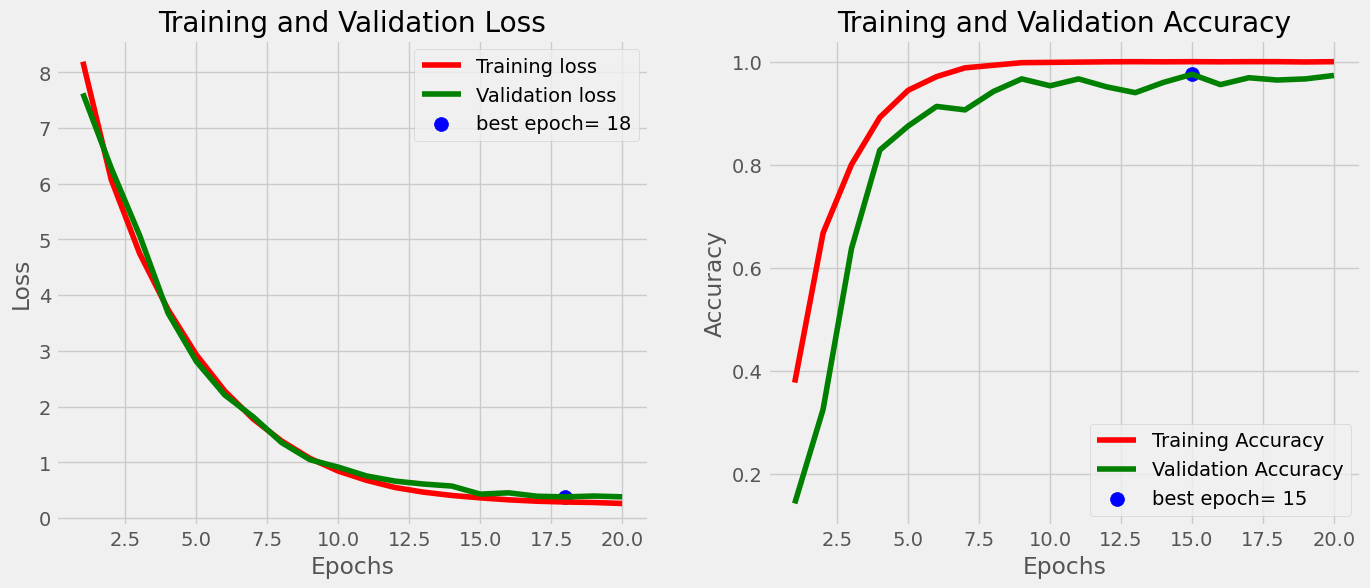

In [ ]:
plot_training(history)

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

113/449 [======>.......................] - ETA: 1:31 - loss: 0.2526 - accuracy: 0.9997

 14/449 [..............................] - ETA: 2:05 - loss: 0.3815 - accuracy: 0.9732

449/449 [==============================] - 17s 38ms/step - loss: 0.3601 - accuracy: 0.9733
Train Loss:  0.25263530015945435
Train Accuracy:  0.9997214674949646
--------------------
Validation Loss:  0.3811786472797394
Validation Accuracy:  0.9732739329338074
--------------------
Test Loss:  0.36006638407707214
Test Accuracy:  0.9732739329338074


In [ ]:
y_pred = model.predict(test_gen)

y_pred_labels = np.argmax(y_pred, axis=1)

y_true_labels = test_gen.classes

449/449 [==============================] - 20s 40ms/step


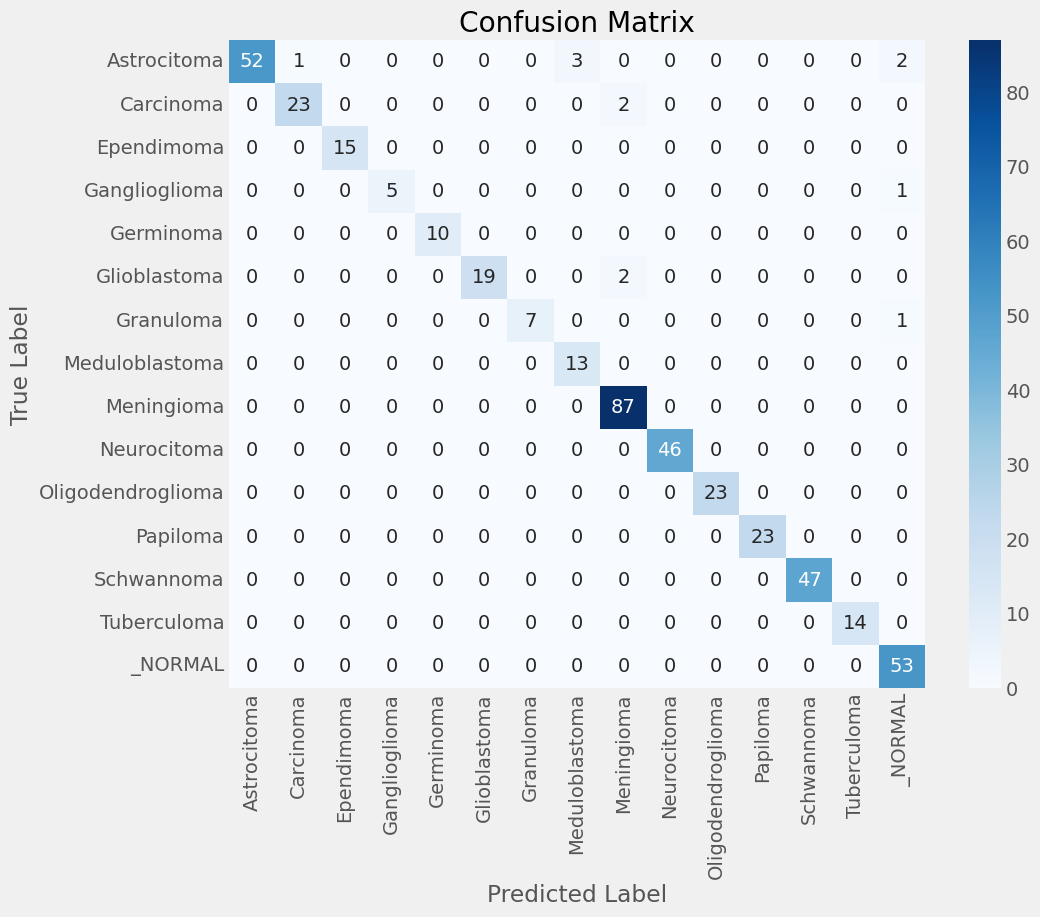

In [ ]:
class_names = list(test_gen.class_indices.keys())

confusion_mtx = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, cmap="Blues", annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
report = classification_report(y_true_labels, y_pred_labels, target_names=class_names)

print("Classification Report: ")
print(report)

Classification Report: 
                   precision    recall  f1-score   support

      Astrocitoma       1.00      0.90      0.95        58
        Carcinoma       0.96      0.92      0.94        25
       Ependimoma       1.00      1.00      1.00        15
    Ganglioglioma       1.00      0.83      0.91         6
        Germinoma       1.00      1.00      1.00        10
     Glioblastoma       1.00      0.90      0.95        21
        Granuloma       1.00      0.88      0.93         8
   Meduloblastoma       0.81      1.00      0.90        13
       Meningioma       0.96      1.00      0.98        87
      Neurocitoma       1.00      1.00      1.00        46
Oligodendroglioma       1.00      1.00      1.00        23
         Papiloma       1.00      1.00      1.00        23
       Schwannoma       1.00      1.00      1.00        47
      Tuberculoma       1.00      1.00      1.00        14
          _NORMAL       0.93      1.00      0.96        53

         accuracy             

## Модель Xception

In [ ]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))


base_model = tf.keras.applications.xception.Xception(include_top= False, 
                                                               weights= "imagenet", 
                                                               input_shape= img_shape, 
                                                               pooling= 'max')

83683744/83683744 [==============================] - 0s 0us/step


In [ ]:
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, 
          kernel_regularizer= regularizers.l2(l= 0.016), 
          activity_regularizer= regularizers.l1(0.006),
          bias_regularizer= regularizers.l1(0.006), 
          activation= 'relu'),
    
    Dropout(rate= 0.45, 
            seed= 123),
    
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 batch_normalization_8 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dense_8 (Dense)             (None, 256)               524544    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 15)                3855      
                                                                 
Total params: 21,398,071
Trainable params: 21,339,447
Non-trainable params: 58,624
_____________________________________

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=10,
                           verbose=1)

checkpoint = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/ВКР/MRI_Xception_model_weights.h5', 
                             monitor='val_loss', 
                             save_best_only=True, 
                             save_weights_only=True, 
                             mode='min', 
                             verbose=1)


history = model.fit(x= train_gen, 
                    epochs= 20, 
                    callbacks=[early_stop, checkpoint],
                    validation_data= valid_gen)

Epoch 1/20
113/113 [==============================] - ETA: 0s - loss: 8.7522 - accuracy: 0.5655
Epoch 1: val_loss improved from inf to 8.06870, saving model to /content/drive/MyDrive/Colab Notebooks/ВКР/MRI_Xception_model_weights.h5
113/113 [==============================] - 97s 589ms/step - loss: 8.7522 - accuracy: 0.5655 - val_loss: 8.0687 - val_accuracy: 0.4321
Epoch 2/20
113/113 [==============================] - ETA: 0s - loss: 6.2238 - accuracy: 0.8565
Epoch 2: val_loss improved from 8.06870 to 6.72637, saving model to /content/drive/MyDrive/Colab Notebooks/ВКР/MRI_Xception_model_weights.h5
113/113 [==============================] - 61s 535ms/step - loss: 6.2238 - accuracy: 0.8565 - val_loss: 6.7264 - val_accuracy: 0.7060
Epoch 3/20
113/113 [==============================] - ETA: 0s - loss: 4.7983 - accuracy: 0.9510
Epoch 3: val_loss improved from 6.72637 to 5.32309, saving model to /content/drive/MyDrive/Colab Notebooks/ВКР/MRI_Xception_model_weights.h5
113/113 [================

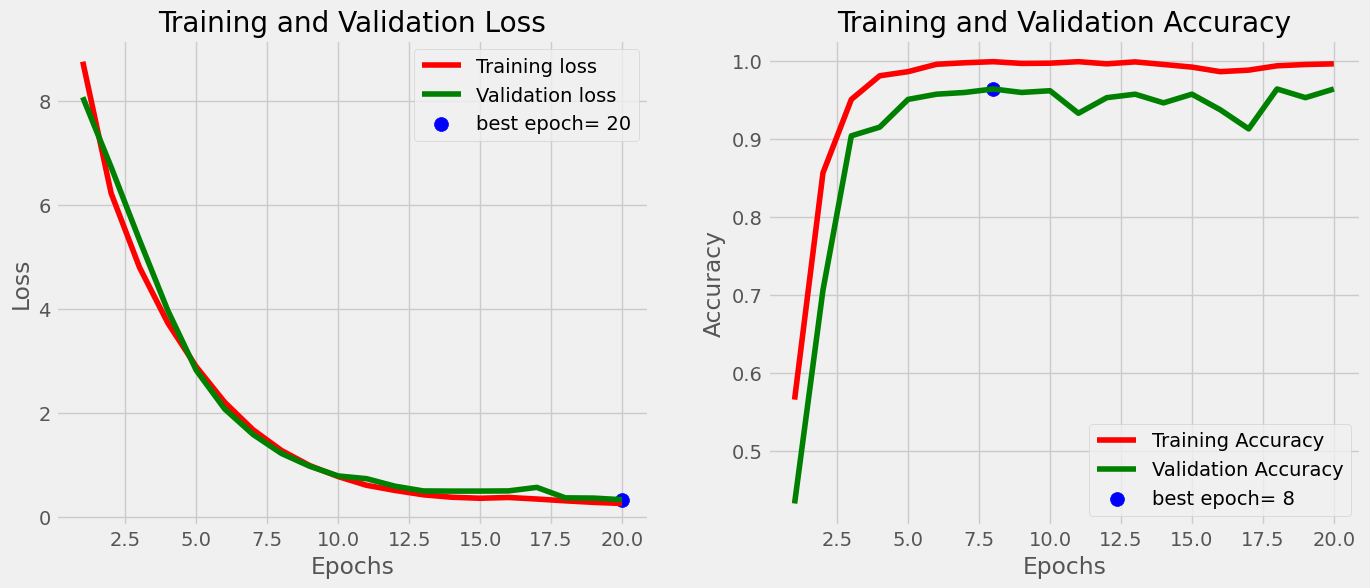

In [ ]:
plot_training(history)

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

112/449 [======>.......................] - ETA: 1:11 - loss: 0.2266 - accuracy: 0.9997

 14/449 [..............................] - ETA: 1:22 - loss: 0.3333 - accuracy: 0.9643

449/449 [==============================] - 6s 14ms/step - loss: 0.3287 - accuracy: 0.9666
Train Loss:  0.22658711671829224
Train Accuracy:  0.9997214674949646
--------------------
Validation Loss:  0.3330879509449005
Validation Accuracy:  0.9643652439117432
--------------------
Test Loss:  0.3286716341972351
Test Accuracy:  0.9665924310684204


In [ ]:
y_pred = model.predict(test_gen)

y_pred_labels = np.argmax(y_pred, axis=1)

y_true_labels = test_gen.classes

449/449 [==============================] - 6s 10ms/step


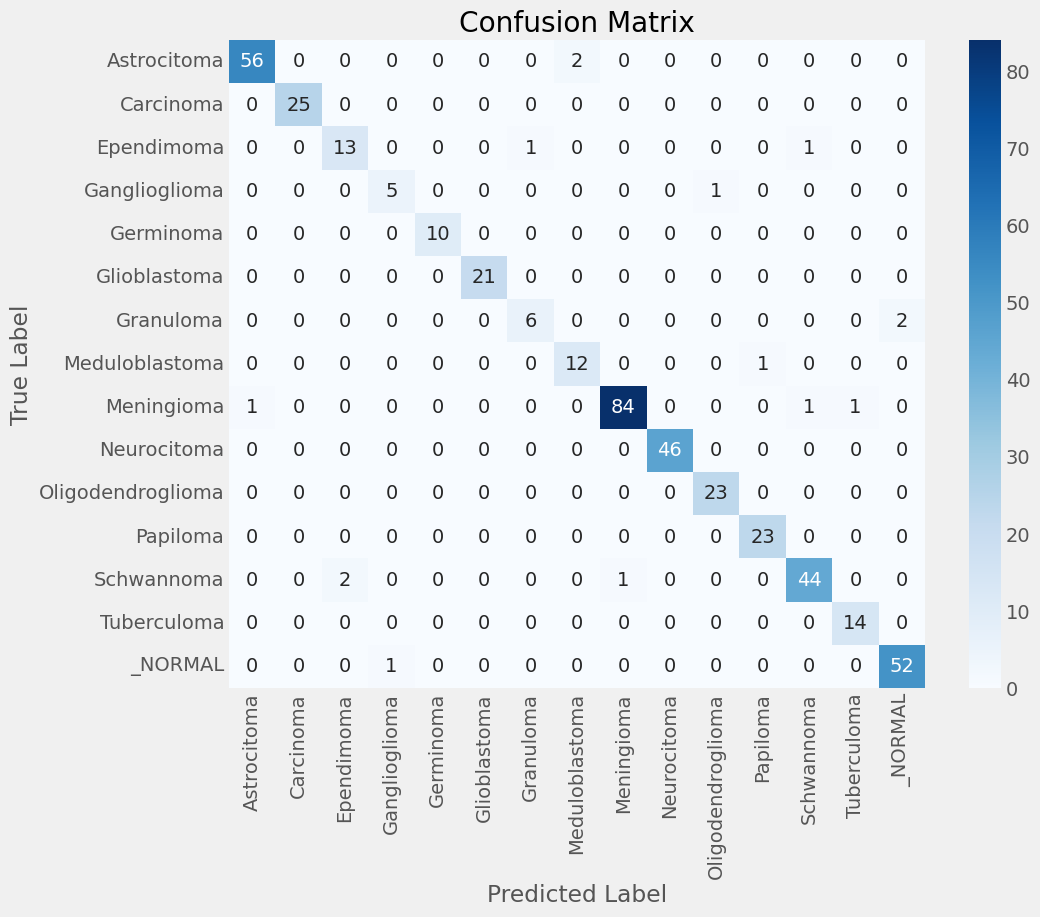

In [ ]:
class_names = list(test_gen.class_indices.keys())

confusion_mtx = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, cmap="Blues", annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
report = classification_report(y_true_labels, y_pred_labels, target_names=class_names)

print("Classification Report: ")
print(report)

Classification Report: 
                   precision    recall  f1-score   support

      Astrocitoma       0.98      0.97      0.97        58
        Carcinoma       1.00      1.00      1.00        25
       Ependimoma       0.87      0.87      0.87        15
    Ganglioglioma       0.83      0.83      0.83         6
        Germinoma       1.00      1.00      1.00        10
     Glioblastoma       1.00      1.00      1.00        21
        Granuloma       0.86      0.75      0.80         8
   Meduloblastoma       0.86      0.92      0.89        13
       Meningioma       0.99      0.97      0.98        87
      Neurocitoma       1.00      1.00      1.00        46
Oligodendroglioma       0.96      1.00      0.98        23
         Papiloma       0.96      1.00      0.98        23
       Schwannoma       0.96      0.94      0.95        47
      Tuberculoma       0.93      1.00      0.97        14
          _NORMAL       0.96      0.98      0.97        53

         accuracy             

## Модель NasNet

In [ ]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))


base_model = tf.keras.applications.nasnet.NASNetMobile(include_top= False, 
                                                               weights= "imagenet", 
                                                               input_shape= img_shape, 
                                                               pooling= 'max')

19993432/19993432 [==============================] - 0s 0us/step


In [ ]:
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, 
          kernel_regularizer= regularizers.l2(l= 0.016), 
          activity_regularizer= regularizers.l1(0.006),
          bias_regularizer= regularizers.l1(0.006), 
          activation= 'relu'),
    
    Dropout(rate= 0.45, 
            seed= 123),
    
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 1056)              4269716   
                                                                 
 batch_normalization_9 (Batc  (None, 1056)             4224      
 hNormalization)                                                 
                                                                 
 dense_10 (Dense)            (None, 256)               270592    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 15)                3855      
                                                                 
Total params: 4,548,387
Trainable params: 4,509,537
Non-trainable params: 38,850
_______________________________________

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=10,
                           verbose=1)

checkpoint = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/ВКР/MRI_NasNet_model_weights.h5', 
                             monitor='val_loss', 
                             save_best_only=True, 
                             save_weights_only=True, 
                             mode='min', 
                             verbose=1)


history = model.fit(x= train_gen, 
                    epochs= 20, 
                    callbacks=[early_stop, checkpoint],
                    validation_data= valid_gen)

Epoch 1/20
113/113 [==============================] - ETA: 0s - loss: 8.2990 - accuracy: 0.5036
Epoch 1: val_loss improved from inf to 9.20102, saving model to /content/drive/MyDrive/Colab Notebooks/ВКР/MRI_NasNet_model_weights.h5
113/113 [==============================] - 177s 401ms/step - loss: 8.2990 - accuracy: 0.5036 - val_loss: 9.2010 - val_accuracy: 0.0891
Epoch 2/20
113/113 [==============================] - ETA: 0s - loss: 6.0684 - accuracy: 0.7666
Epoch 2: val_loss improved from 9.20102 to 8.33179, saving model to /content/drive/MyDrive/Colab Notebooks/ВКР/MRI_NasNet_model_weights.h5
113/113 [==============================] - 40s 353ms/step - loss: 6.0684 - accuracy: 0.7666 - val_loss: 8.3318 - val_accuracy: 0.1203
Epoch 3/20
113/113 [==============================] - ETA: 0s - loss: 4.7021 - accuracy: 0.8813
Epoch 3: val_loss improved from 8.33179 to 7.37097, saving model to /content/drive/MyDrive/Colab Notebooks/ВКР/MRI_NasNet_model_weights.h5
113/113 [=====================

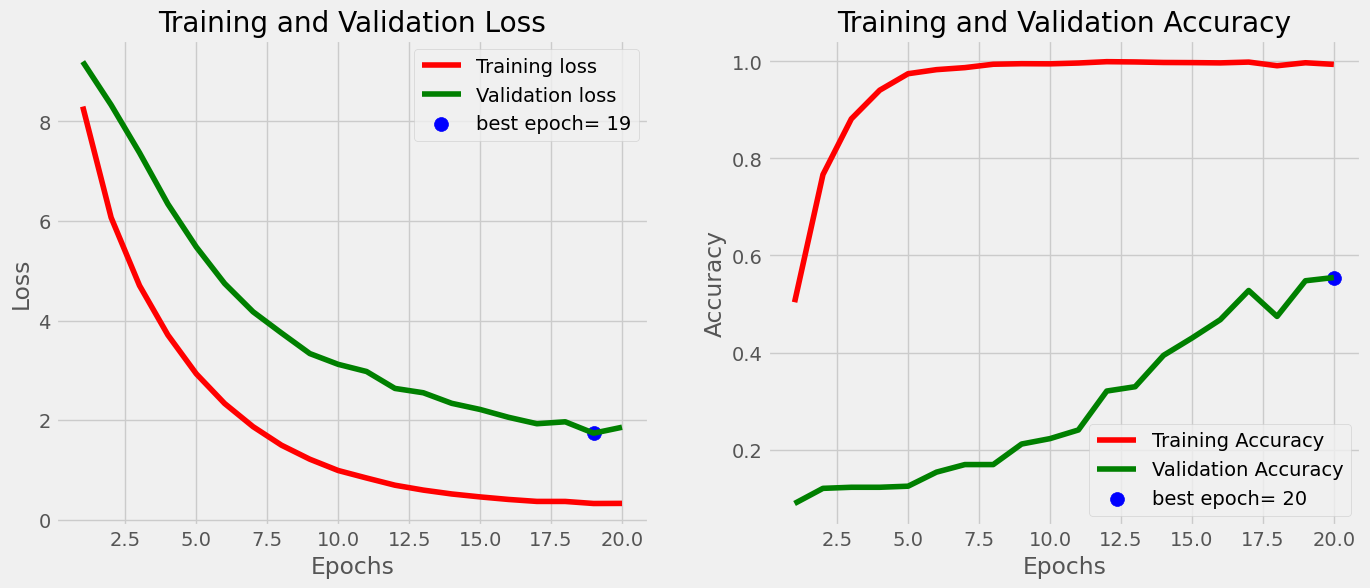

In [ ]:
plot_training(history)

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

112/449 [======>.......................] - ETA: 1:10 - loss: 1.8072 - accuracy: 0.5421

 14/449 [..............................] - ETA: 1:21 - loss: 1.8541 - accuracy: 0.5536

449/449 [==============================] - 13s 29ms/step - loss: 1.9548 - accuracy: 0.4900
Train Loss:  1.8077231645584106
Train Accuracy:  0.5417827367782593
--------------------
Validation Loss:  1.8548791408538818
Validation Accuracy:  0.5545657277107239
--------------------
Test Loss:  1.9548115730285645
Test Accuracy:  0.48997771739959717


In [ ]:
y_pred = model.predict(test_gen)

y_pred_labels = np.argmax(y_pred, axis=1)

y_true_labels = test_gen.classes

449/449 [==============================] - 16s 27ms/step


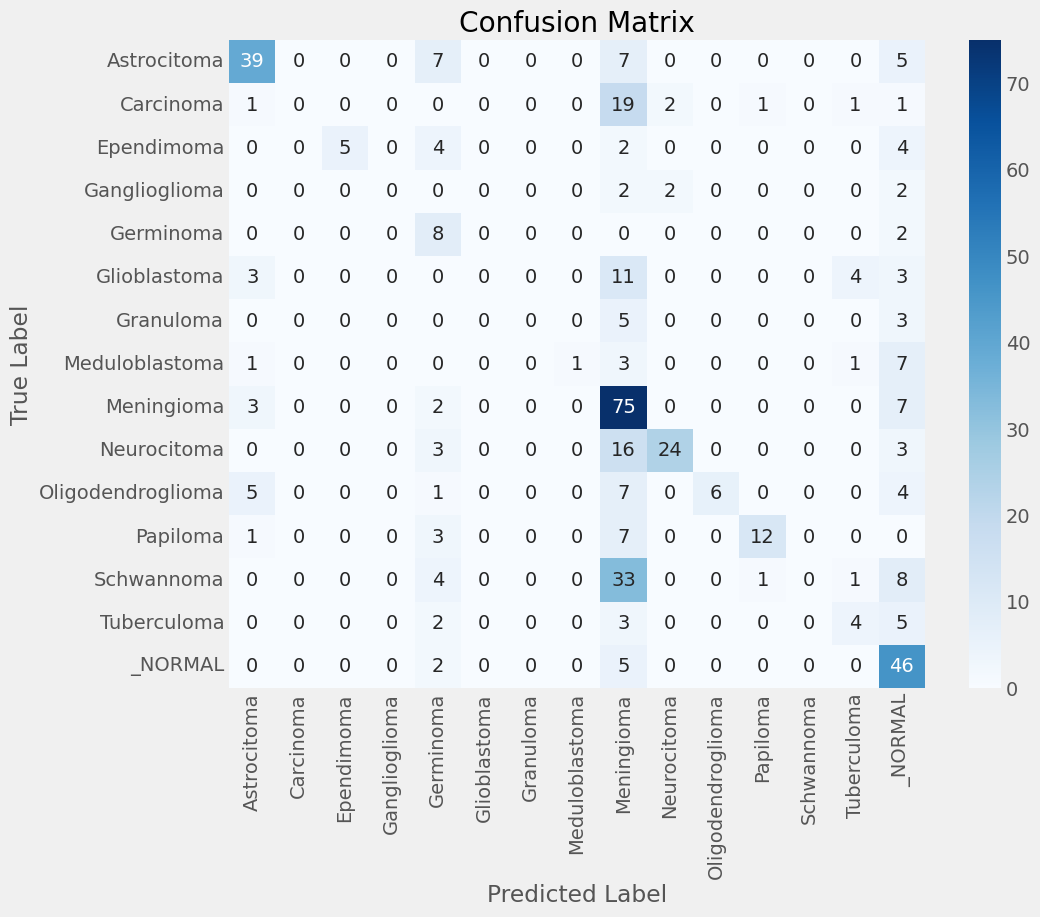

In [ ]:
class_names = list(test_gen.class_indices.keys())

confusion_mtx = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, cmap="Blues", annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
report = classification_report(y_true_labels, y_pred_labels, target_names=class_names)

print("Classification Report: ")
print(report)

Classification Report: 
                   precision    recall  f1-score   support

      Astrocitoma       0.74      0.67      0.70        58
        Carcinoma       0.00      0.00      0.00        25
       Ependimoma       1.00      0.33      0.50        15
    Ganglioglioma       0.00      0.00      0.00         6
        Germinoma       0.22      0.80      0.35        10
     Glioblastoma       0.00      0.00      0.00        21
        Granuloma       0.00      0.00      0.00         8
   Meduloblastoma       1.00      0.08      0.14        13
       Meningioma       0.38      0.86      0.53        87
      Neurocitoma       0.86      0.52      0.65        46
Oligodendroglioma       1.00      0.26      0.41        23
         Papiloma       0.86      0.52      0.65        23
       Schwannoma       0.00      0.00      0.00        47
      Tuberculoma       0.36      0.29      0.32        14
          _NORMAL       0.46      0.87      0.60        53

         accuracy             

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Модель InceptionResNetV2

In [ ]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))


base_model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(include_top= False, 
                                                               weights= "imagenet", 
                                                               input_shape= img_shape, 
                                                               pooling= 'max')

219055592/219055592 [==============================] - 1s 0us/step


In [ ]:
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, 
          kernel_regularizer= regularizers.l2(l= 0.016), 
          activity_regularizer= regularizers.l1(0.006),
          bias_regularizer= regularizers.l1(0.006), 
          activation= 'relu'),
    
    Dropout(rate= 0.45, 
            seed= 123),
    
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 1536)             54336736  
 onal)                                                           
                                                                 
 batch_normalization_203 (Ba  (None, 1536)             6144      
 tchNormalization)                                               
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 15)                3855      
                                                                 
Total params: 54,740,207
Trainable params: 54,676,591
No

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=10,
                           verbose=1)

checkpoint = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/ВКР/MRI_InceptionResNetV2_model_weights.h5', 
                             monitor='val_loss', 
                             save_best_only=True, 
                             save_weights_only=True, 
                             mode='min', 
                             verbose=1)


history = model.fit(x= train_gen, 
                    epochs= 20, 
                    callbacks=[early_stop, checkpoint],
                    validation_data= valid_gen)

Epoch 1/20
113/113 [==============================] - ETA: 0s - loss: 8.8171 - accuracy: 0.5117
Epoch 1: val_loss improved from inf to 11.77575, saving model to /content/drive/MyDrive/Colab Notebooks/ВКР/MRI_InceptionResNetV2_model_weights.h5
113/113 [==============================] - 888s 7s/step - loss: 8.8171 - accuracy: 0.5117 - val_loss: 11.7758 - val_accuracy: 0.5546
Epoch 2/20
113/113 [==============================] - ETA: 0s - loss: 6.6546 - accuracy: 0.7811
Epoch 2: val_loss improved from 11.77575 to 6.71347, saving model to /content/drive/MyDrive/Colab Notebooks/ВКР/MRI_InceptionResNetV2_model_weights.h5
113/113 [==============================] - 69s 607ms/step - loss: 6.6546 - accuracy: 0.7811 - val_loss: 6.7135 - val_accuracy: 0.7817
Epoch 3/20
113/113 [==============================] - ETA: 0s - loss: 5.5419 - accuracy: 0.8894
Epoch 3: val_loss improved from 6.71347 to 5.67301, saving model to /content/drive/MyDrive/Colab Notebooks/ВКР/MRI_InceptionResNetV2_model_weights.

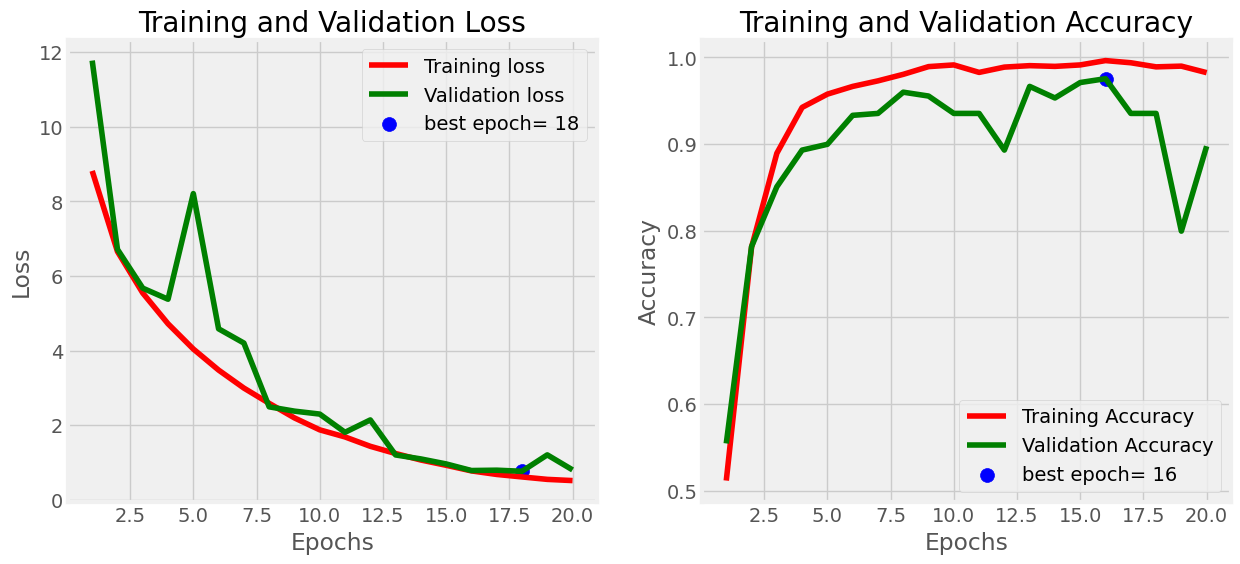

In [ ]:
plot_training(history)

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

113/449 [======>.......................] - ETA: 1:20 - loss: 0.4958 - accuracy: 0.9710

 14/449 [..............................] - ETA: 1:37 - loss: 0.8001 - accuracy: 0.8973

449/449 [==============================] - 94s 210ms/step - loss: 0.7685 - accuracy: 0.8909
Train Loss:  0.4957984685897827
Train Accuracy:  0.9710306525230408
--------------------
Validation Loss:  0.7991394996643066
Validation Accuracy:  0.897550106048584
--------------------
Test Loss:  0.7684823870658875
Test Accuracy:  0.890868604183197


In [ ]:
y_pred = model.predict(test_gen)

y_pred_labels = np.argmax(y_pred, axis=1)

y_true_labels = test_gen.classes

449/449 [==============================] - 15s 25ms/step


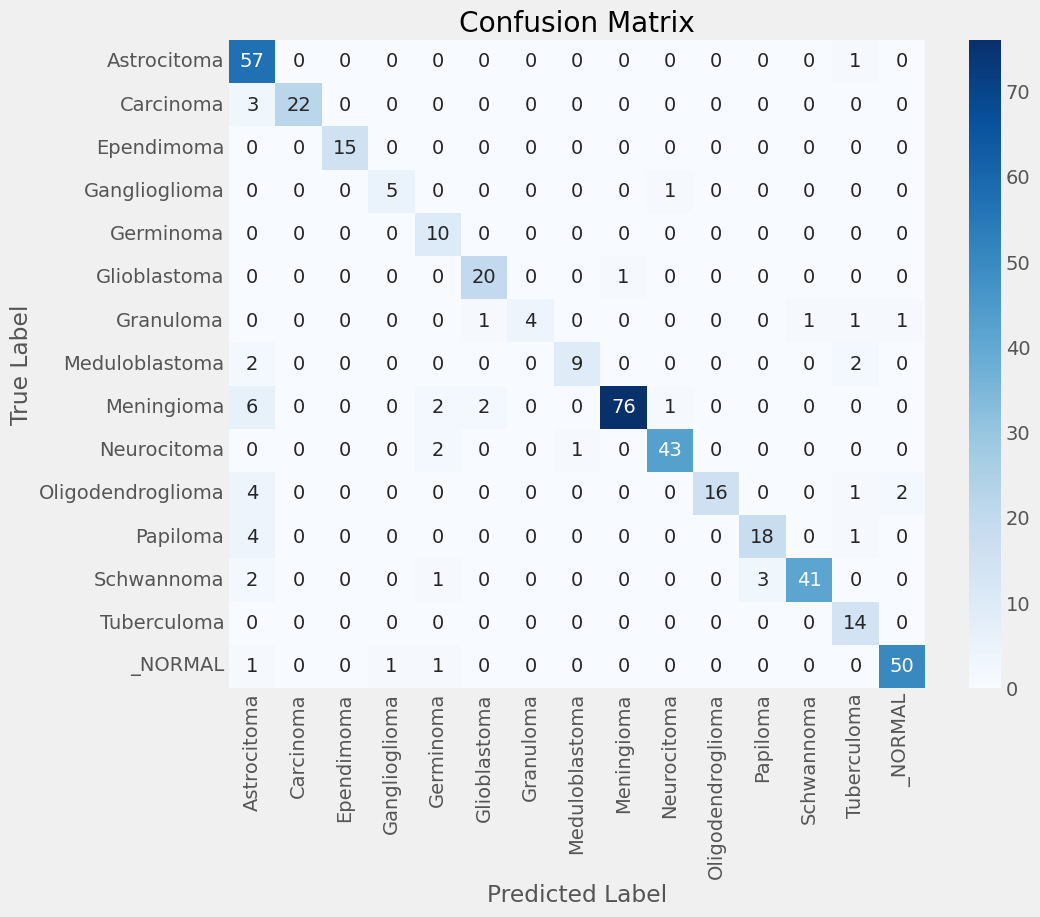

In [ ]:
class_names = list(test_gen.class_indices.keys())

confusion_mtx = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, cmap="Blues", annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
report = classification_report(y_true_labels, y_pred_labels, target_names=class_names)

print("Classification Report: ")
print(report)

Classification Report: 
                   precision    recall  f1-score   support

      Astrocitoma       0.72      0.98      0.83        58
        Carcinoma       1.00      0.88      0.94        25
       Ependimoma       1.00      1.00      1.00        15
    Ganglioglioma       0.83      0.83      0.83         6
        Germinoma       0.62      1.00      0.77        10
     Glioblastoma       0.87      0.95      0.91        21
        Granuloma       1.00      0.50      0.67         8
   Meduloblastoma       0.90      0.69      0.78        13
       Meningioma       0.99      0.87      0.93        87
      Neurocitoma       0.96      0.93      0.95        46
Oligodendroglioma       1.00      0.70      0.82        23
         Papiloma       0.86      0.78      0.82        23
       Schwannoma       0.98      0.87      0.92        47
      Tuberculoma       0.70      1.00      0.82        14
          _NORMAL       0.94      0.94      0.94        53

         accuracy             